# Using NLP on Educational Reform Policies to Predict Educational Outcome
### Feature Importance and Category Analysis

In [2]:
# Import Statements
import pandas as pd
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [3]:
# Load dataframe
final_df = pd.read_csv('../Data/final_pisa_werd_merged.csv')

#### Feature Importance

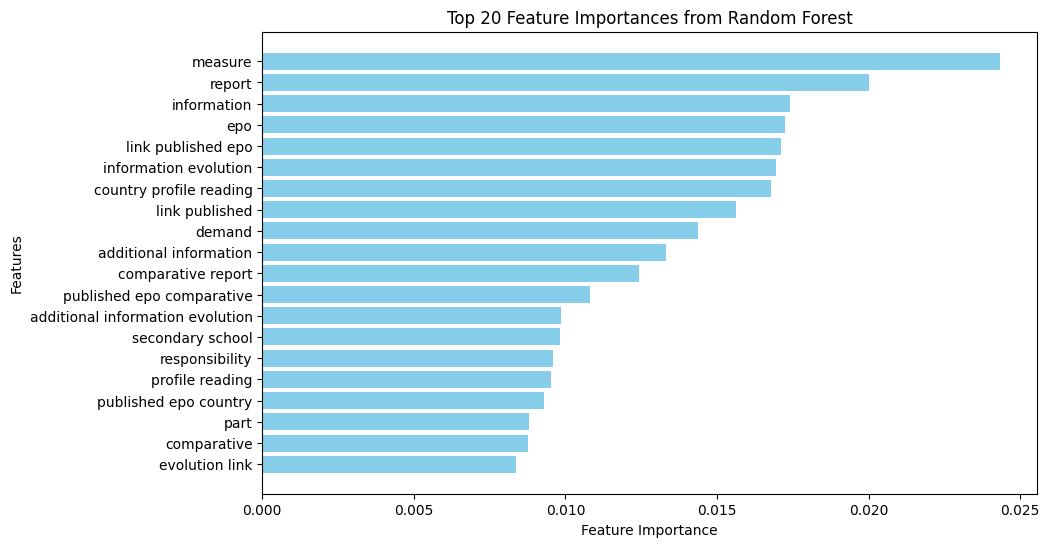

In [4]:
X_train = final_df['reform_description_clean']
y_train = final_df['Mean_Last_PISA_Score'].values

vectorizer = CountVectorizer(ngram_range=(1, 3), max_features=1000)
X_train_transformed = vectorizer.fit_transform(X_train)

feature_names = vectorizer.get_feature_names_out()

rf_model = RandomForestRegressor(n_estimators=75, random_state=42, max_depth=10, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_jobs=-1)
rf_model.fit(X_train_transformed, y_train)

rf_feature_importance = rf_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'RandomForest': rf_feature_importance
})

importance_df.sort_values(by='RandomForest', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:20], importance_df['RandomForest'][:20], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 20 Feature Importances from Random Forest')
plt.gca().invert_yaxis()
plt.show()

#### Category Analysis

In [5]:
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(final_df['reform_description_clean'])

lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(X)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

topic_assignments = lda.transform(X).argmax(axis=1)
final_df['reform_category'] = topic_assignments

topic_labels = {
    0: 'Higher Education and Vocational Training',
    1: 'Child and Policy-Focused Reforms',
    2: 'Primary Education and Teaching',
    3: 'Skills and Qualification Development',
    4: 'Information and Curriculum Development'
}

final_df['reform_category'] = final_df['reform_category'].map(topic_labels)

X_train = vectorizer.transform(final_df['reform_description_clean'])
y_train = final_df['Mean_Last_PISA_Score'].values

rf_model = RandomForestRegressor(n_estimators=75, random_state=42, max_depth=10, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_jobs=-1)
rf_model.fit(X_train, y_train)

xgb_model = xgb.XGBRegressor(colsample_bytree = 1.0, learning_rate = 0.1, max_depth = 9, min_child_weight = 1, n_estimators = 100, subsample = 0.7)
xgb_model.fit(X_train, y_train)

def vectorize_text(text_list):
    return vectorizer.transform(text_list)

def calculate_impact(df, rf_model, xgb_model):
    X = vectorize_text(df['reform_description_clean'].tolist())
    rf_impact = rf_model.predict(X).mean()
    xgb_impact = xgb_model.predict(X).mean()
    return pd.Series({'RandomForestImpact': rf_impact, 'XGBoostImpact': xgb_impact})

category_impact = final_df.groupby('reform_category').apply(lambda df: calculate_impact(df, rf_model, xgb_model))

category_impact.sort_values(by='RandomForestImpact', ascending=False, inplace=True)

print(category_impact)

Topic 0:
act university vocational training programme ministry compulsory reform institution study
Topic 1:
training program law child institution policy ministry state project plan
Topic 2:
decree training law program teaching evaluation primary social university reform
Topic 3:
act skill child training support qualification teaching information programme published
Topic 4:
programme link information law additional reading published training epo http
                                          RandomForestImpact  XGBoostImpact
reform_category                                                            
Skills and Qualification Development              483.265477     496.836548
Information and Curriculum Development            467.359661     473.707794
Higher Education and Vocational Training          447.267479     451.218140
Child and Policy-Focused Reforms                  410.156523     407.564850
Primary Education and Teaching                    392.234074     383.670410
